In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

Using Heart disease UCI dataset for ML Governance and explainability

In [3]:
heart_disease = fetch_ucirepo(id = 45)

In [4]:
X = heart_disease.data.features
y = heart_disease.data.targets

In [5]:
X.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0

In [6]:
#Binning based on age

bins = [0, 39, 60, 120] #bins for <40, 40 - 60, >60
labels = ['< 40', '40-60', '> 60']

#Creating a new column 'age category' with the binned ages
X['age_category'] = pd.cut(X['age'], bins = bins , labels = labels, right = True)

In [7]:
X.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal age_category  
0  0.0   6.0         > 60  
1  3.0   3.0         > 60  
2  2.0   7.0         > 60  
3  0.0   3.0         < 40  
4  0.0   3.0        40-60

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [11]:
sex = X['sex']
age_category = X['age_category']

X_train, X_test, y_train, y_test, A_train, A_test, age_train, age_test = train_test_split(X, y, sex, age_category, test_size = 0.2, random_state = 42)

In [12]:
#encoding age_category

le = LabelEncoder()
X_train['age_category'] = le.fit_transform(X_train['age_category'])
X_test['age_category'] = le.transform(X_test['age_category'])

X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
132   29    1   2       130   204    0        2      202      0      0.0   
202   57    1   3       150   126    1        0      173      0      0.2   
196   69    1   1       160   234    1        2      131      0      0.1   
75    65    0   3       160   360    0        2      151      0      0.8   
176   52    1   4       108   233    1        0      147      0      0.1   

     slope   ca  thal  age_category  
132      1  0.0   3.0             1  
202      1  1.0   7.0             0  
196      2  1.0   3.0             2  
75       1  0.0   3.0             2  
176      1  3.0   7.0             0

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
imputer = SimpleImputer(strategy='mean') 


numerical_features = ['ca', 'thal', 'age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', imputer, numerical_features),
        
        
    ],
    remainder='passthrough'
).set_output( transform="pandas" )


pipeline = Pipeline([
    ('preprocessor', preprocessor),
]
)


X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Fairlearn explaination

**Demographic Parity Difference**

Demographic parity is a fairness concept that stipulates that the likelihood of a model making a certain prediction should be the same for all demographic groups. In simpler terms, the selection rate (the proportion of individuals receiving a positive outcome) should be equal across groups defined by sensitive attributes like race, gender, or age.

A demographic parity difference of zero indicates that the model's predictions are perfectly fair according to this metric, meaning all groups have the same selection rate. A larger value signifies a greater disparity in outcomes between groups

In [17]:
from fairlearn.metrics import demographic_parity_difference

print("Demographic Parity Difference:", demographic_parity_difference(y_test, y_test_pred, sensitive_features=A_test))
print("Demographic Parity Difference:", demographic_parity_difference(y_train, y_train_pred, sensitive_features=A_train))

print("Demographic Parity Difference:", demographic_parity_difference(y_test, y_test_pred, sensitive_features=age_test))
print("Demographic Parity Difference:", demographic_parity_difference(y_train, y_train_pred, sensitive_features=age_train))



Demographic Parity Difference: 0.013677811550151978
Demographic Parity Difference: 0.18867924528301888
Demographic Parity Difference: 0.2727272727272727
Demographic Parity Difference: 0.13414634146341464


**Equalized Odds Difference**

Equalized odds is a more stringent fairness criterion that takes into account the actual ground truth labels. It requires that the model's prediction rates for both true positives and false positives are equal across different demographic groups. This means the model should perform equally well for all groups, both in correctly identifying positive instances and in avoiding incorrect positive predictions.

An equalized odds difference of zero signifies that the model is fair under this metric, meaning both the true positive rate and the false positive rate are the same for all demographic groups. A higher value indicates a greater disparity in the model's error rates across groups.


In [18]:
import numpy as np
from fairlearn.metrics import equalized_odds_difference

classes = np.unique(y_test)

results = {}

for cls in classes:
    # Convert to binary: current class vs rest
    y_true_bin = (y_test == cls).astype(int)
    y_pred_bin = (y_test_pred == cls).astype(int)

    diff = equalized_odds_difference(
        y_true=y_true_bin,
        y_pred=y_pred_bin,
        sensitive_features=A_test
    )
    results[cls] = diff

print("Equalized Odds Difference (per class):")
for cls, val in results.items():
    print(f"Class {cls}: {val}")


Equalized Odds Difference (per class):
Class 0: 0.2857142857142857
Class 1: 0.09090909090909091
Class 2: 0.16666666666666666
Class 3: 0.2857142857142857
Class 4: 0.0


MetricFrame is a specialized tool for calculating and comparing performance metrics across different demographic groups in your dataset. It takes your model's predictions, the true labels, and the sensitive features (like race, gender, or age) and organizes them into a convenient structure for fairness analysis. This allows you to see not just the overall performance of your model, but also how it performs for each specific group.

In [19]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from fairlearn.metrics import MetricFrame

metrics_to_report = {
    "balanced_accuracy": balanced_accuracy_score,
    "precision_macro": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro"),
    "recall_macro": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro"),
}

mf = MetricFrame(
    metrics=metrics_to_report,
    y_true=y_test,
    y_pred=y_test_pred,
    sensitive_features=A_test
)

print("Overall metrics:")
print(mf.overall)

print("\nGroup-wise metrics:")
print(mf.by_group)


Overall metrics:
balanced_accuracy    0.304461
precision_macro      0.280000
recall_macro         0.304461
dtype: float64

Group-wise metrics:
     balanced_accuracy  precision_macro  recall_macro
sex                                                  
0             0.411111         0.454545      0.308333
1             0.298132         0.264103      0.298132


c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\sklearn\metrics\_classificati

Overall Metrics
balanced_accuracy: 0.304461: This is a low score. A random guess in a binary classification problem would yield a balanced accuracy of 0.5. Your model's ability to correctly identify both classes, on average, is quite poor across the entire dataset.

precision_macro: 0.280000: This indicates that, on average, when your model predicts a class, it is correct only about 28% of the time. This is a very low precision, suggesting a high number of false positives.

recall_macro: 0.304461: This tells you that your model correctly identifies only about 30.4% of the actual positive samples for each class, on average. This is also a low recall, indicating a high number of false negatives.

In this case, the balanced_accuracy and recall_macro have the same value, which can happen depending on the data distribution and model predictions, but it's not always the case.

Group-wise Metrics
This is where we assess the fairness of your model. We're comparing its performance between two groups, likely "male" and "female," represented by sex 0 and sex 1.

Group 0 (sex 0):

balanced_accuracy: 0.411111: The model performs better for this group compared to the overall score, but it's still not great.

precision_macro: 0.454545: Precision is significantly higher for this group.

recall_macro: 0.308333: Recall is similar to the overall recall.

Group 1 (sex 1):

balanced_accuracy: 0.298132: The model's performance is notably worse for this group.

precision_macro: 0.264103: Precision is much lower for this group.

recall_macro: 0.298132: Recall is also slightly lower for this group.

What This Means for Fairness
The disparity in the group-wise metrics reveals a fairness issue. Your model is not performing equally for both groups. Specifically:

Group 0 is favored: The model has a higher balanced accuracy and much higher precision for this group.

Group 1 is disadvantaged: The model's performance is considerably worse for this group across all metrics.

This kind of discrepancy is what fairness-aware machine learning aims to address. Your model may be learning biases present in the training data, leading it to be less accurate and more prone to errors for one group over another.



# SHAP Explaination

In [21]:
import shap

c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
shap.initjs()

Each SHAP summary plot is a rich visualization that reveals how different features impact the model's prediction for a single, specific class. It's designed to show not just which features are important, but also how their values affect the outcome.

Here’s a breakdown of a single plot for one class (e.g., "Class 1"):

Y-Axis (Features): Features are listed vertically, ranked by their overall importance. The most influential feature for predicting "Class 1" is at the top.

X-Axis (SHAP Value): This axis shows the impact of a feature on the model's prediction for that class.

Positive SHAP Value: A value to the right of the center line means that the feature's value pushed the prediction towards "Class 1" (i.e., increased the probability of predicting "Class 1").

Negative SHAP Value: A value to the left means the feature's value pushed the prediction away from "Class 1".

Color (Feature Value): The color of each point indicates whether the feature's value for that specific data point was high (usually shown in red/pink) or low (usually shown in blue).

Generating SHAP summary plot for class 0...


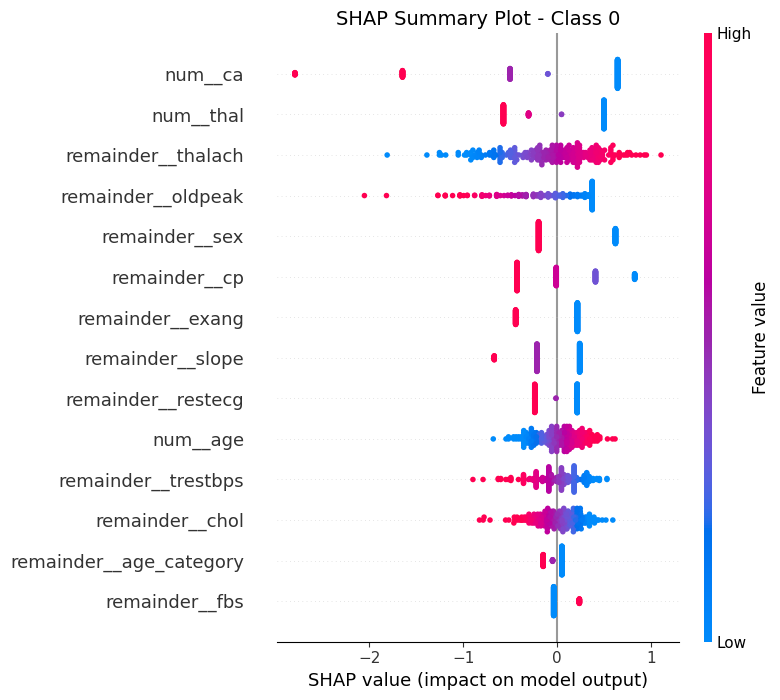

Generating SHAP summary plot for class 1...


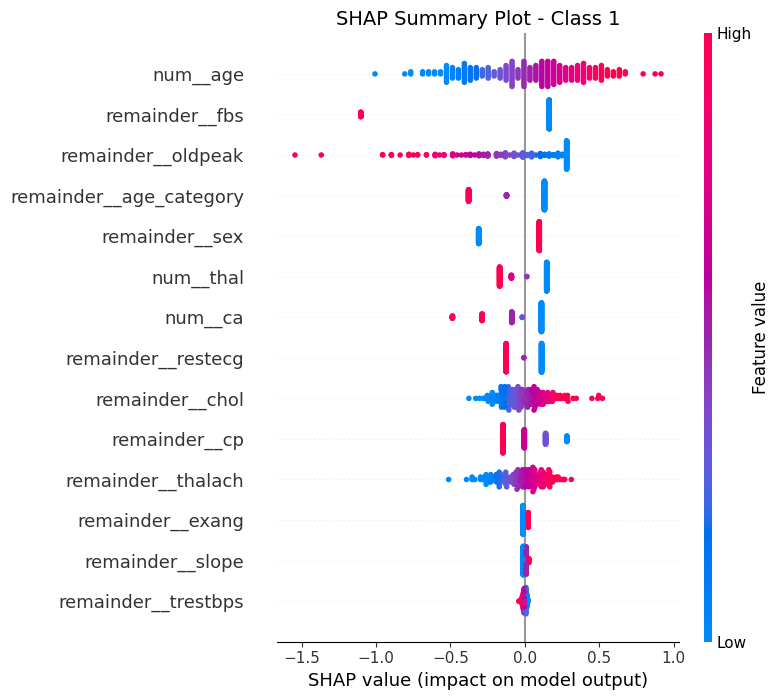

Generating SHAP summary plot for class 2...


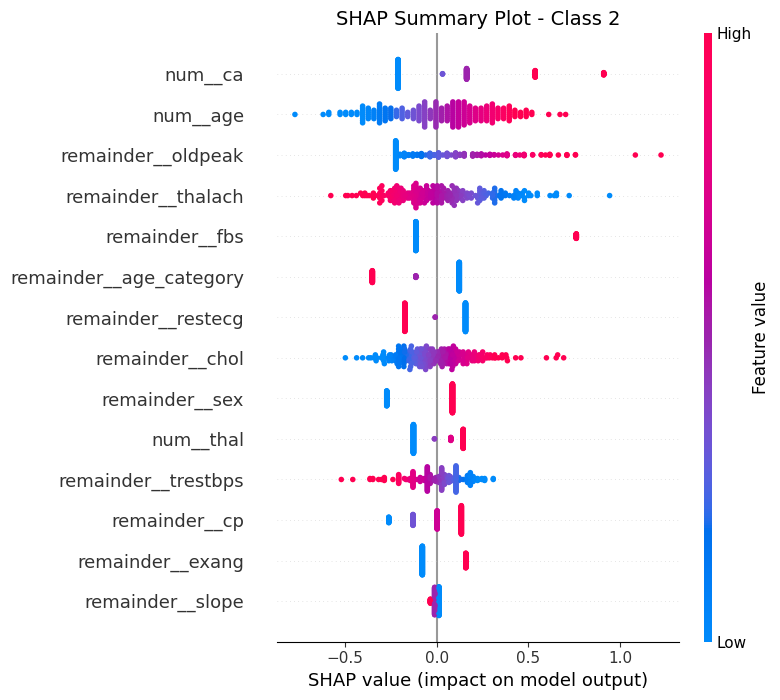

Generating SHAP summary plot for class 3...


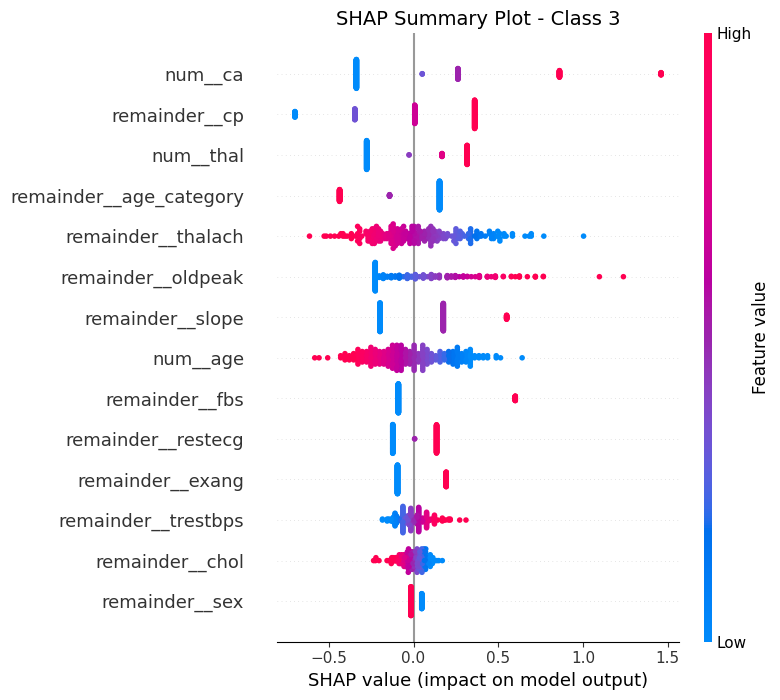

Generating SHAP summary plot for class 4...


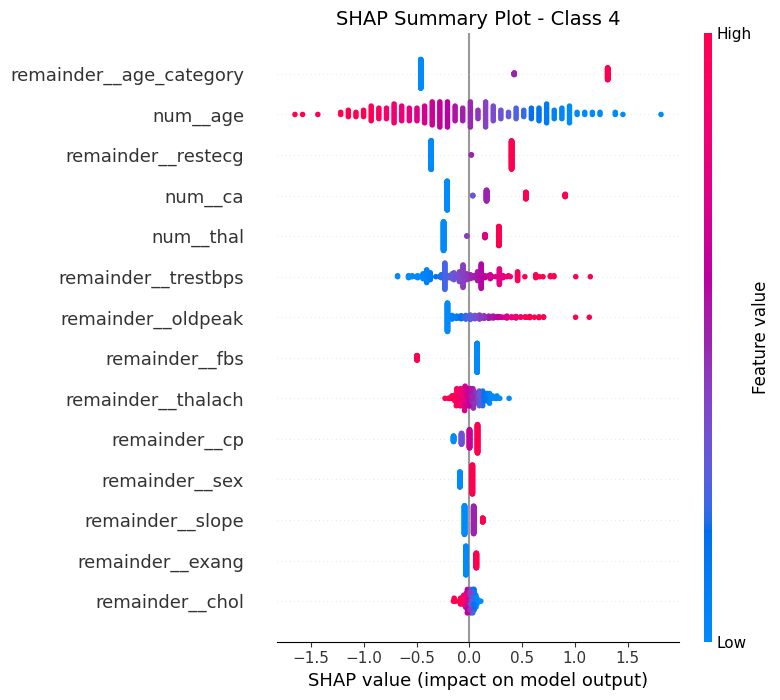

In [23]:
import matplotlib.pyplot as plt

# Assuming X_train is a DataFrame with column names
explainer = shap.Explainer(model, X_train, model_output="probability")
shap_values = explainer(X_train)

# Number of target classes
n_classes = shap_values.values.shape[-1]

# Generate summary plot for each class
for class_idx in range(n_classes):
    print(f"Generating SHAP summary plot for class {class_idx}...")
    shap.summary_plot(
        shap_values[..., class_idx],
        X_train,
        show=False
    )
    plt.title(f"SHAP Summary Plot - Class {class_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [24]:
class_idx = 1
sample_idx = 0

# pick out values and base value for that class
vals = shap_values.values[sample_idx, :, class_idx]
base_val = shap_values.base_values[sample_idx, class_idx]

# rebuild Explanation object for just this sample & class
single_expl = shap.Explanation(
    values=vals,
    base_values=base_val,
    data=X.iloc[sample_idx],
    feature_names=X.columns
)

# now force plot works
shap.plots.force(single_expl)


# Evidently Explaination

In [26]:
from evidently import Report
from evidently.presets import DataDriftPreset

In [27]:
report = Report([
    DataDriftPreset()
],
include_tests="True")
my_eval = report.run(X_train, X_test)
my_eval.save_html("data_drift_report.html")

c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\scipy\stats\_stats_py.py:7400: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\scipy\stats\_stats_py.py:7400: RuntimeWarning:

divide by zero encountered in divide

c:\Users\user\Downloads\ML Governance\.MLgov_env\Lib\site-packages\scipy\stats\_stats_py.py:7400: RuntimeWarning:

divide by zero encountered in divide



In [28]:
my_eval